In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Flatten , InputLayer ,Input
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision ,Recall , Accuracy , F1Score
import tensorflow_datasets as tfds
import tensorflow as tf

2024-02-19 22:04:27.406122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 22:04:27.406177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 22:04:27.407589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset, dataset_info = tfds.load('malaria',
                                  with_info = True,
                                  as_supervised= True,
                                  shuffle_files= True,
                                  split=['train'])

In [3]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [4]:
dataset = dataset[0]

In [5]:
def split_dataset(dataset  , train_size , test_size ,val_size = 0):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(DATASET_SIZE*train_size))
  test_dataset = dataset.skip(int(DATASET_SIZE*train_size)).take(int(DATASET_SIZE*test_size))
  val_dataset = dataset.skip(int(DATASET_SIZE*train_size)).skip(int(DATASET_SIZE*test_size))
  return train_dataset, test_dataset ,val_dataset

In [6]:
lists = [10,10,3 ,4,5,6,8,9,0,14]
DATASET_SIZE = len(dataset)
TRAIN_RATIO =0.8
TEST_RATIO =0.1
VAL_RATIO =0.1

In [7]:
DATASET_SIZE

27558

In [8]:
train_dataset, test_dataset ,val_dataset = split_dataset(dataset  , TRAIN_RATIO , TEST_RATIO ,VAL_RATIO)

In [9]:
len(test_dataset)

2755

In [10]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
train_dataset.take(1).as_numpy_iterator()

In [12]:
list_train = list(train_dataset.take(1).as_numpy_iterator())

In [13]:
list_train

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]

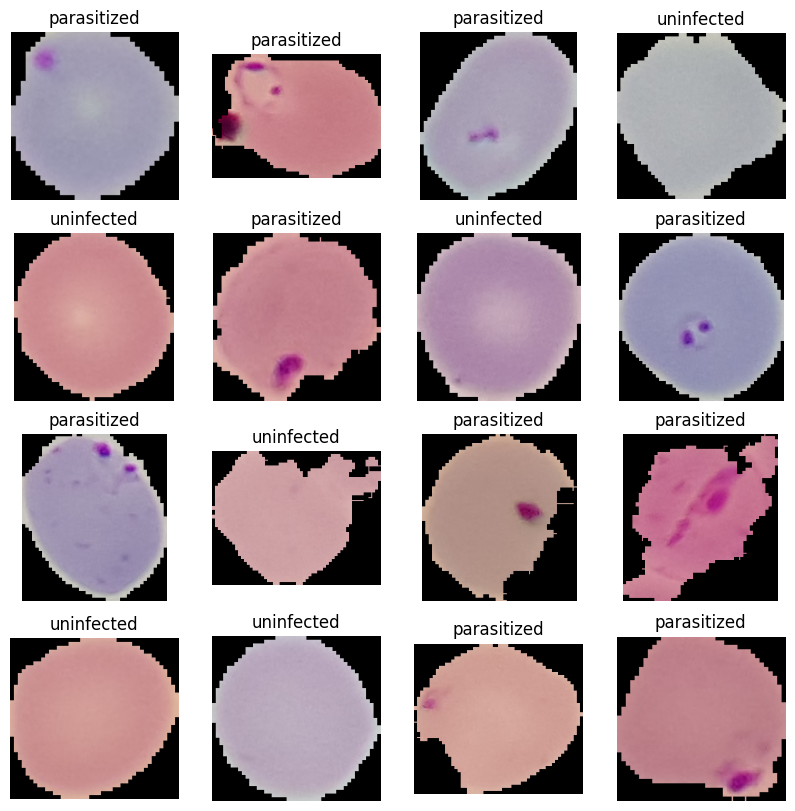

In [14]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [15]:
IMAGE_SIZE = 224

In [16]:
def image_resize_normalize (image , label ) :
  image = tf.image.resize(image , (IMAGE_SIZE ,IMAGE_SIZE)) /255
  return image , label

In [17]:
train_dataset =  train_dataset.map(image_resize_normalize)
test_dataset =  test_dataset.map(image_resize_normalize)
val_dataset = val_dataset.map(image_resize_normalize)

In [18]:
for data in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(112, 115, 3), dtype=uint8) tf.Tensor(0, shape=(), dtype=int64)


In [19]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
val_dataset = val_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
test_dataset = test_dataset.shuffle(buffer_size = 8 ,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [22]:
class Mymodel(tf.keras.models.Model):
    def __init__(self , IMAGE_SIZE):
        super(Mymodel , self).__init__()
        self.conv2D_1 = Conv2D(filters = 6 ,kernel_size= 3 ,padding ='valid' , activation = 'relu')
        self.batchnorm_1 = BatchNormalization()
        self.maxpooling_1 = MaxPooling2D(pool_size=(2,2) , strides=2)
        
        self.conv2D_2 = Conv2D(filters = 16 ,kernel_size= 3 ,padding ='valid' , activation = 'relu')
        self.batchnorm_2 = BatchNormalization()
        self.maxpooling_2 = MaxPooling2D(pool_size=(2,2) , strides=2)
        
        self.flatten = Flatten()
        
        self.dense_1 = Dense(100 , activation = 'relu')
        self.batchnorm_3 = BatchNormalization()

        
        self.dense_2 = Dense(10 , activation = 'relu')
        self.batchnorm_4 = BatchNormalization()

        
        self.output_layer = Dense(1 , activation = 'sigmoid')
        
    def call(self , inputs):

        x = self.conv2D_1(inputs)
        x = self.batchnorm_1(x)
        x = self.maxpooling_1(x)
        
        x = self.conv2D_2(x)
        x = self.batchnorm_2(x)
        x = self.maxpooling_2(x)
        
        x = self.flatten(x)
        
        x = self.dense_1(x) 
        x = self.batchnorm_3(x)
        x = self.dense_2(x) 
        x = self.batchnorm_4(x)
        output = self.output_layer(x) 
        
        return output

In [39]:
input_tensor = Input(shape = (IMAGE_SIZE ,IMAGE_SIZE ,3))
model = Mymodel(IMAGE_SIZE)
output = model(input_tensor)

In [24]:
model

In [25]:
model.summary()

Model: "mymodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  168       
                                                                 
 batch_normalization (Batch  multiple                  24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  880       
                                                                 
 batch_normalization_1 (Bat  multiple                  64        
 chNormalization)                                                
                                                           

In [26]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

def F1Score(y_true, y_pred, precision=precision, recall=recall):
    precision.update_state(y_true, y_pred)
    recall.update_state(y_true, y_pred)
    precision_result = precision.result()
    recall_result = recall.result()
    return (2 * precision_result * recall_result) / (precision_result + recall_result + tf.keras.backend.epsilon())

In [27]:
 metrics=['accuracy',
          
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                  F1Score,
          
                    
]

In [28]:
model.compile(optimizer = Adam(learning_rate= 0.01),
loss = BinaryCrossentropy(),
              metrics = metrics,
              )

In [29]:
history = model.fit(train_dataset , validation_data=val_dataset ,epochs=5 , verbose = 1)

Epoch 1/5


I0000 00:00:1708380277.606665    2924 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


689/689 [==============================] - 29s 34ms/step - loss: 0.4430 - accuracy: 0.7800 - precision_1: 0.7800 - recall_1: 0.7800 - F1Score: 0.6824 - val_loss: 1.3077 - val_accuracy: 0.7570 - val_precision_1: 0.6756 - val_recall_1: 0.9787 - val_F1Score: 0.7815
Epoch 2/5
689/689 [==============================] - 23s 33ms/step - loss: 0.1938 - accuracy: 0.9349 - precision_1: 0.9243 - recall_1: 0.9474 - F1Score: 0.8250 - val_loss: 1.1042 - val_accuracy: 0.8357 - val_precision_1: 0.7533 - val_recall_1: 0.9919 - val_F1Score: 0.8543
Epoch 3/5
689/689 [==============================] - 23s 33ms/step - loss: 0.1700 - accuracy: 0.9462 - precision_1: 0.9359 - recall_1: 0.9581 - F1Score: 0.8703 - val_loss: 0.1831 - val_accuracy: 0.9427 - val_precision_1: 0.9159 - val_recall_1: 0.9736 - val_F1Score: 0.8838
Epoch 4/5
689/689 [==============================] - 22s 32ms/step - loss: 0.1544 - accuracy: 0.9506 - precision_1: 0.9397 - recall_1: 0.9632 - F1Score: 0.8931 - val_loss: 0.2399 - val_accura

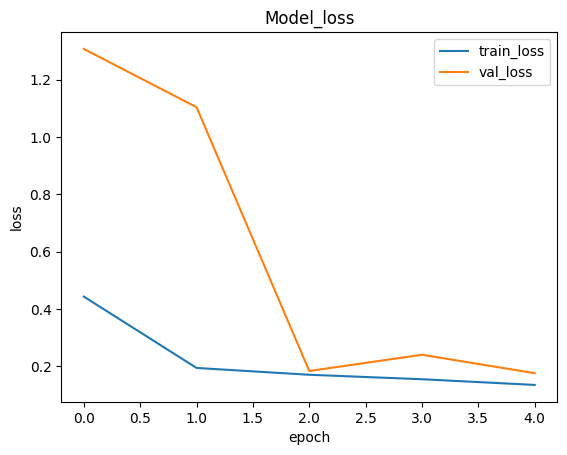

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

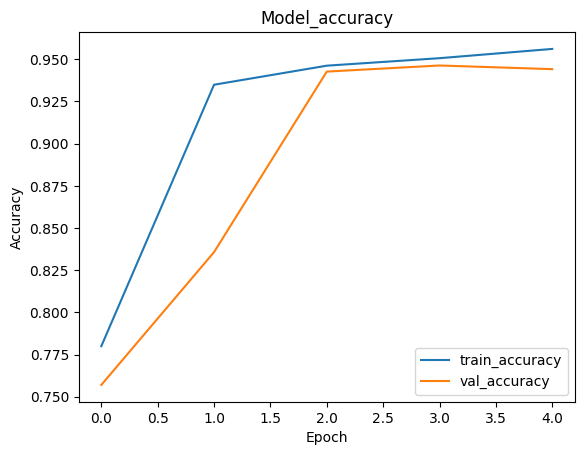

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [32]:
model.evaluate(test_dataset)

87/87 [==============================] - 7s 20ms/step - loss: 0.1733 - accuracy: 0.9466 - precision_1: 0.9253 - recall_1: 0.9726 - F1Score: 0.9124


[0.17325946688652039,
 0.9466424584388733,
 0.9253424406051636,
 0.972642183303833,
 0.9123907685279846]

In [33]:
def paraside_or_not(x):
  if(x < 0.5):
    return str('parasitized')
  else:
    return str('Uninfected')

1/1 [==============================] - 0s 33ms/step


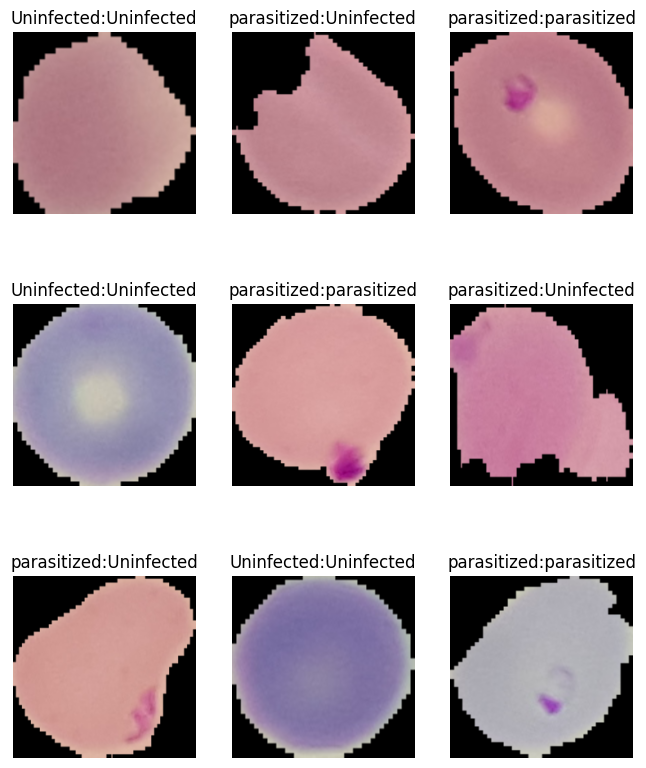

In [34]:
plt.figure(figsize=(8,10))
for i, (image, label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(paraside_or_not(label.numpy()[0])) + ":" +str(paraside_or_not(model.predict(image)[0][0])))
  plt.axis('off')

In [35]:
y_pred = model.predict(test_dataset)

87/87 [==============================] - 7s 16ms/step


In [36]:
y_test = list(test_dataset.take(1).as_numpy_iterator())

In [37]:
y_test

[(array([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          ...,
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
  
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           ...,
           [0., 0., 0.],
           [0., 